## Basic Pandas

Introduces the concept of a `DataFrame` in Python. If you're familiar with R, it's pretty much the same idea! Useful cheat sheet [here](https://www.datacamp.com/community/blog/pandas-cheat-sheet-python#gs.59HV6BY)

The main purpose of Pandas is to allow easy manipulation of data in tabular form. Perhaps the most important idea that makes Pandas great for data science, is that it will always preserve **alignment** between data and labels.

In [1]:
import pandas as pd
import numpy as np
import glob 

The most common data structure in Pandas is the `DataFrame`. A 2D structure that can hold various types of Python objects indexed by an `index` array (or multiple `index` arrays). Columns are usually labelled as well using strings.

An easy way to think about a `DataFrame` is if you imagine it as an Excel spreadsheet.

Pandas also reads files from disk in tabular form ([here](http://pandas.pydata.org/pandas-docs/version/0.20/io.html)'s a list of all the formats that it can read and write). A very common one is CSV, so let's load one!

In [4]:
df = pd.read_csv("../data/shankle.csv")
df.head()

Facies Formation Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       2     A1 SH   SHANKLE  2774.5  98.36      0.642      -0.1  18.685   
1       2     A1 SH   SHANKLE  2775.0  97.57      0.631       7.9  16.745   
2       2     A1 SH   SHANKLE  2775.5  98.41      0.615      12.8  14.105   
3       2     A1 SH   SHANKLE  2776.0  85.92      0.597      13.0  13.385   
4       2     A1 SH   SHANKLE  2776.5  83.16      0.592      12.3  13.345   

    PE  NM_M  RELPOS  
0  2.9     1   1.000  
1  3.2     1   0.984  
2  3.2     1   0.968  
3  3.4     1   0.952  
4  3.4     1   0.935

But we have a few wells and we would like to load them all at once and and make a single `DataFrame` object.

In [5]:
ls ../data/*.csv

../data/churchmanbible.csv  ../data/newby.csv      ../data/shankle.csv
../data/crosshcattle.csv    ../data/nolan.csv      ../data/shrimplin.csv
../data/lukegu.csv          ../data/recruitf9.csv


In [6]:
glob.glob('../data/*.csv')

['../data/shrimplin.csv',
 '../data/nolan.csv',
 '../data/newby.csv',
 '../data/shankle.csv',
 '../data/churchmanbible.csv',
 '../data/crosshcattle.csv',
 '../data/lukegu.csv',
 '../data/recruitf9.csv']

`glob.glob('PATH')` returns a list that matches the pattern or file in the 'PATH' string.

In [7]:
wells = []
for well in glob.glob('../data/*.csv'):
    wells.append(pd.read_csv(well))

`wells` contains 8 `DataFrame` objects. We can use `pandas` to concatenate them into a single `DataFrame`

In [8]:
df = pd.concat(wells, sort=False)

 - Create a new column called "ILD" and store in it the value of 10 to the power of the values in column "ILD_log10".

 - How many different facies are part of the `DataFrame`?.

In [9]:
df['ILD'] = 10**df["ILD_log10"]

In [10]:
df.groupby('Facies').size()

Facies
1    259
2    738
3    615
4    184
5    217
6    462
7     98
8    498
9    161
dtype: int64

# Inspecting the `DataFrame`

Using the `DataFrame` with well log information loaded before, we can make a summary using the `describe()` method of the `DataFrame` object

In [11]:
df.describe()

Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  3232.000000  3232.000000  3232.000000  3232.000000  3232.000000   
mean      4.422030  2875.824567    66.135769     0.642719     3.559642   
std       2.504243   131.006274    30.854826     0.241845     5.228948   
min       1.000000  2573.500000    13.250000    -0.025949   -21.832000   
25%       2.000000  2791.000000    46.918750     0.492750     1.163750   
50%       4.000000  2893.500000    65.721500     0.624437     3.500000   
75%       6.000000  2980.000000    79.626250     0.812735     6.432500   
max       9.000000  3122.500000   361.150000     1.480000    18.600000   

             PHIND           PE         NM_M       RELPOS          ILD  
count  3232.000000  3232.000000  3232.000000  3232.000000  3232.000000  
mean     13.483213     3.725014     1.498453     0.520287     5.131699  
std       7.698980     0.896152     0.500075     0.286792     3.091769  
min       0.550000     0.200000     1.000000     0.010000     0.942000  
25%       8.346750     3.100000     1.000000     0.273000     3.109927  
50%      12.150000     3.551500     1.000000     0.526000     4.211500  
75%      16.453750     4.300000     2.000000     0.767250     6.497324  
max      84.400000     8.094000     2.000000     1.000000    30.199517

In [12]:
df = df.dropna()

## Adding more data to the `DataFrame`

We'd like to augment the DataFrame with some new data, based on some of the existing data.

In [13]:
def calc_phi_rhob(phind, deltaphi):
    """
    Compute phi_RHOB from phi_ND and Delta_phi.
    """
    return 2 * (phind/100) / (1 - deltaphi/100) - deltaphi/100

In [14]:
def calc_rhob(phi_rhob, rho_matrix=2650.0, rho_fluid=1000.0):
    """
    Returns density porosity log.
    
    Some typical values for rho_matrix:
      Sandstone:  2650 kg/m^3
      Limestone:  2710 kg/m^3
      Dolomite:   2880 kg/m^3
      Anyhydrite: 2980 kg/m^3
      Salt:       2030 kg/m^3

    Some typical values for rho_fluid:
      Fresh water: 1000 kg/m^3
      Salt water:  1100 kg/m^3
      Heavy oil:   1000 kg/m^3
      Light oil:    800 kg/m^3
      LNG:          650 kg/m^3
    
    See wiki.aapg.org/Density-neutron_log_porosity
    """
    return rho_matrix * (1 - phi_rhob) + rho_fluid * phi_rhob

In [15]:
phi_rhob = calc_phi_rhob(df.PHIND, df.DeltaPHI)
df['RHOB'] = calc_rhob(phi_rhob)

In [16]:
df.describe()

Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  3232.000000  3232.000000  3232.000000  3232.000000  3232.000000   
mean      4.422030  2875.824567    66.135769     0.642719     3.559642   
std       2.504243   131.006274    30.854826     0.241845     5.228948   
min       1.000000  2573.500000    13.250000    -0.025949   -21.832000   
25%       2.000000  2791.000000    46.918750     0.492750     1.163750   
50%       4.000000  2893.500000    65.721500     0.624437     3.500000   
75%       6.000000  2980.000000    79.626250     0.812735     6.432500   
max       9.000000  3122.500000   361.150000     1.480000    18.600000   

             PHIND           PE         NM_M       RELPOS          ILD  \
count  3232.000000  3232.000000  3232.000000  3232.000000  3232.000000   
mean     13.483213     3.725014     1.498453     0.520287     5.131699   
std       7.698980     0.896152     0.500075     0.286792     3.091769   
min       0.550000     0.200000     1.000000     0.010000     0.942000   
25%       8.346750     3.100000     1.000000     0.273000     3.109927   
50%      12.150000     3.551500     1.000000     0.526000     4.211500   
75%      16.453750     4.300000     2.000000     0.767250     6.497324   
max      84.400000     8.094000     2.000000     1.000000    30.199517   

              RHOB  
count  3232.000000  
mean   2248.911086  
std     271.200640  
min    -159.040816  
25%    2153.808486  
50%    2315.516920  
75%    2420.208001  
max    2812.733802

We can define a Python dictionary to relate facies with the integer label on the `DataFrame`

In [17]:
facies_dict = {1:'sandstone', 2:'c_siltstone', 3:'f_siltstone', 4:'marine_silt_shale',
               5:'mudstone', 6:'wackestone', 7:'dolomite', 8:'packstone', 9:'bafflestone'}

Let's add a new column with the name version of the facies

In [18]:
df["s_Facies"] = [facies_dict.get(x, "Unknown") for x in df.Facies]

In [19]:
df.head(20)

Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0        3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1        3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2        3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3        3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4        3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   
5        3     A1 SH  SHRIMPLIN  2795.5  73.97      0.636      14.0  13.385   
6        3     A1 SH  SHRIMPLIN  2796.0  73.72      0.630      15.6  13.930   
7        3     A1 SH  SHRIMPLIN  2796.5  75.65      0.625      16.5  13.920   
8        3     A1 SH  SHRIMPLIN  2797.0  73.79      0.624      16.2  13.980   
9        3     A1 SH  SHRIMPLIN  2797.5  76.89      0.615      16.9  14.220   
10       3     A1 SH  SHRIMPLIN  2798.0  76.11      0.600      14.8  13.375   
11       3     A1 SH  SHRIMPLIN  2798.5  74.95      0.583      13.3  12.690   
12       3     A1 SH  SHRIMPLIN  2799.0  71.87      0.561      11.3  12.475   
13       3     A1 SH  SHRIMPLIN  2799.5  83.42      0.537      13.3  14.930   
14       2     A1 SH  SHRIMPLIN  2800.0  90.10      0.519      14.3  16.555   
15       2     A1 SH  SHRIMPLIN  2800.5  78.15      0.467      11.8  15.960   
16       2     A1 SH  SHRIMPLIN  2801.0  69.30      0.438       9.5  15.120   
17       2     A1 SH  SHRIMPLIN  2801.5  63.54      0.418       8.8  15.190   
18       2     A1 SH  SHRIMPLIN  2802.0  63.87      0.401       7.2  15.390   
19       2     A1 SH  SHRIMPLIN  2802.5  58.32      0.386       6.6  14.885   

     PE  NM_M  RELPOS       ILD         RHOB     s_Facies  
0   4.6     1   1.000  4.613176  2376.951554  f_siltstone  
1   4.1     1   0.979  4.581419  2401.030769  f_siltstone  
2   3.6     1   0.957  4.549881  2388.742254  f_siltstone  
3   3.5     1   0.936  4.518559  2376.684495  f_siltstone  
4   3.4     1   0.915  4.436086  2365.351156  f_siltstone  
5   3.6     1   0.894  4.325138  2367.389535  f_siltstone  
6   3.7     1   0.872  4.265795  2362.743602  f_siltstone  
7   3.5     1   0.830  4.216965  2372.118263  f_siltstone  
8   3.4     1   0.809  4.207266  2366.774940  f_siltstone  
9   3.5     1   0.787  4.120975  2364.156859  f_siltstone  
10  3.6     1   0.766  3.981072  2376.154225  f_siltstone  
11  3.7     1   0.745  3.828247  2386.439619  f_siltstone  
12  3.5     1   0.723  3.639150  2372.329369  f_siltstone  
13  3.4     1   0.702  3.443499  2301.180104  f_siltstone  
14  3.2     1   0.681  3.303695  2248.476254  c_siltstone  
15  3.1     1   0.638  2.930893  2247.557143  c_siltstone  
16  3.1     1   0.617  2.741574  2255.412983  c_siltstone  
17  3.0     1   0.596  2.618183  2245.561842  c_siltstone  
18  2.9     1   0.574  2.517677  2221.526293  c_siltstone  
19  2.8     1   0.553  2.432204  2232.984582  c_siltstone

## Visual exploration of the data

We can easily visualize the properties of each facies and how they compare using a `PairPlot`. The library `seaborn` integrates with matplotlib to make these kind of plots easily.

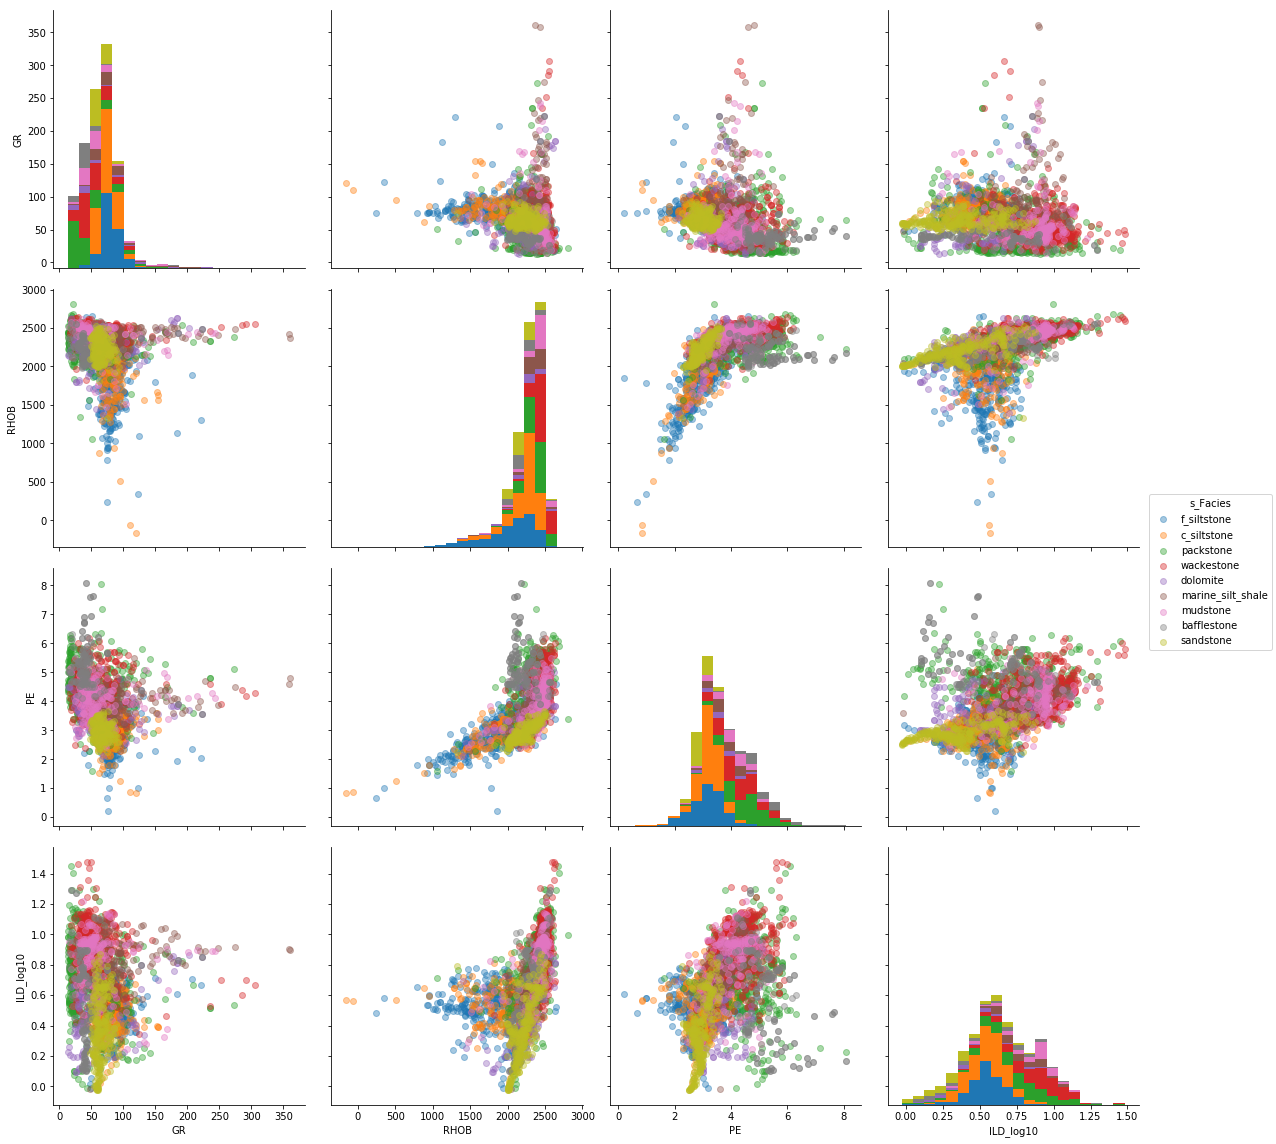

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g = sns.PairGrid(df, hue="s_Facies", vars=['GR','RHOB','PE','ILD_log10'], size=4)

g.map_upper(plt.scatter, alpha=0.4)  
g.map_lower(plt.scatter, alpha=0.4)
g.map_diag(plt.hist, bins=20)  
g.add_legend()

It is very clear that it's hard to separate these facies in feature space. Let's just select a couple of facies and using Pandas, select the rows in the `DataFrame` that contain information about those facies 

In [21]:
selected = ['f_siltstone', 'bafflestone', 'wackestone']

dfs = pd.concat([df[df.s_Facies == x] for x in selected])

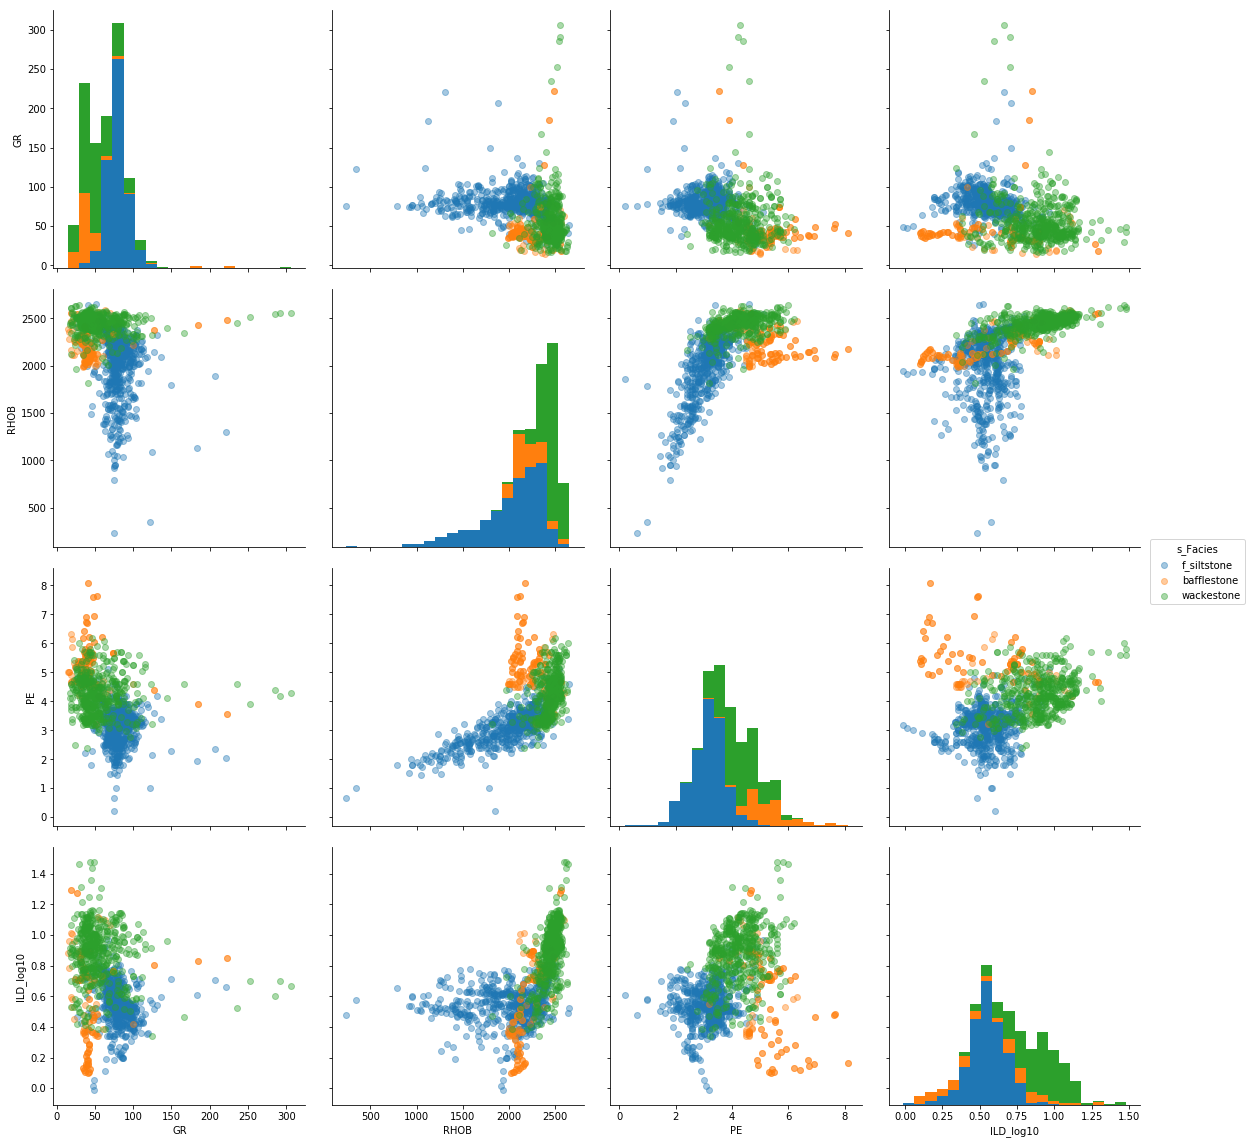

In [22]:
g = sns.PairGrid(dfs, hue="s_Facies", vars=['GR','RHOB','PE','ILD_log10'], size=4)  
g.map_upper(plt.scatter, alpha=0.4)
g.map_lower(plt.scatter, alpha=0.4)
g.map_diag(plt.hist, bins=20)  
g.add_legend()

Let's unpack that:

In [23]:
pd.concat([df[df.s_Facies == x] for x in selected])

Facies Formation  Well Name   Depth      GR  ILD_log10  DeltaPHI   PHIND  \
0         3     A1 SH  SHRIMPLIN  2793.0   77.45      0.664       9.9  11.915   
1         3     A1 SH  SHRIMPLIN  2793.5   78.26      0.661      14.2  12.565   
2         3     A1 SH  SHRIMPLIN  2794.0   79.05      0.658      14.8  13.050   
3         3     A1 SH  SHRIMPLIN  2794.5   86.10      0.655      13.9  13.115   
4         3     A1 SH  SHRIMPLIN  2795.0   74.58      0.647      13.5  13.300   
5         3     A1 SH  SHRIMPLIN  2795.5   73.97      0.636      14.0  13.385   
6         3     A1 SH  SHRIMPLIN  2796.0   73.72      0.630      15.6  13.930   
7         3     A1 SH  SHRIMPLIN  2796.5   75.65      0.625      16.5  13.920   
8         3     A1 SH  SHRIMPLIN  2797.0   73.79      0.624      16.2  13.980   
9         3     A1 SH  SHRIMPLIN  2797.5   76.89      0.615      16.9  14.220   
10        3     A1 SH  SHRIMPLIN  2798.0   76.11      0.600      14.8  13.375   
11        3     A1 SH  SHRIMPLIN  2798.5   74.95      0.583      13.3  12.690   
12        3     A1 SH  SHRIMPLIN  2799.0   71.87      0.561      11.3  12.475   
13        3     A1 SH  SHRIMPLIN  2799.5   83.42      0.537      13.3  14.930   
25        3     A1 SH  SHRIMPLIN  2805.5   69.48      0.354       5.8  14.675   
26        3     A1 SH  SHRIMPLIN  2806.0   76.37      0.354       5.2  13.635   
33        3     A1 SH  SHRIMPLIN  2809.5   54.29      0.470       9.9   9.440   
34        3     A1 SH  SHRIMPLIN  2810.0   41.46      0.493      11.1   5.255   
35        3     A1 SH  SHRIMPLIN  2810.5   50.93      0.524      12.1   5.265   
36        3     A1 SH  SHRIMPLIN  2811.0   72.79      0.543      11.3  11.760   
37        3     A1 SH  SHRIMPLIN  2811.5   95.34      0.555      14.1  17.665   
38        3     A1 SH  SHRIMPLIN  2812.0  102.35      0.558      15.8  20.145   
39        3     A1 SH  SHRIMPLIN  2812.5   79.70      0.549      15.5  18.070   
40        3     A1 SH  SHRIMPLIN  2813.0   66.69      0.530      14.0  15.720   
94        3     B1 SH  SHRIMPLIN  2840.0  107.77      0.713       1.8  19.545   
95        3     B1 SH  SHRIMPLIN  2840.5  110.87      0.686       6.0  26.650   
96        3     B1 SH  SHRIMPLIN  2841.0  106.33      0.665       8.6  26.940   
97        3     B1 SH  SHRIMPLIN  2841.5   87.85      0.640       9.6  21.770   
98        3     B1 SH  SHRIMPLIN  2842.0   80.96      0.601       9.0  15.990   
108       3     B1 SH  SHRIMPLIN  2847.0   84.46      0.486       6.1  20.480   
..      ...       ...        ...     ...     ...        ...       ...     ...   
410       6      C LM   LUKE G U  2817.0   43.79      0.932       9.1   6.550   
411       6      C LM   LUKE G U  2817.5   51.07      0.932       8.4   6.900   
412       6      C LM   LUKE G U  2818.0   49.55      0.955       5.7   5.750   
413       6      C LM   LUKE G U  2818.5   42.49      0.979       3.5   4.850   
414       6      C LM   LUKE G U  2819.0   48.45      1.007       3.5   5.050   
415       6      C LM   LUKE G U  2819.5   54.59      1.044       3.9   5.450   
416       6      C LM   LUKE G U  2820.0   56.75      1.053       3.5   5.450   
417       6      C LM   LUKE G U  2820.5   48.11      1.044       2.8   5.500   
418       6      C LM   LUKE G U  2821.0   41.37      1.016       2.3   5.650   
419       6      C LM   LUKE G U  2821.5   40.62      0.997       1.8   6.000   
420       6      C LM   LUKE G U  2822.0   43.16      0.988       1.7   6.350   
421       6      C LM   LUKE G U  2822.5   46.73      0.969       2.6   7.100   
422       6      C LM   LUKE G U  2823.0   51.04      0.960       3.7   8.150   
423       6      C LM   LUKE G U  2823.5   54.56      0.979       3.6   8.200   
424       6      C LM   LUKE G U  2824.0   53.58      1.007       3.4   7.800   
425       6      C LM   LUKE G U  2824.5   50.00      1.081       2.5   6.750   
426       6      C LM   LUKE G U  2825.0   46.51      1.100       0.7   5.350   
427       6      C LM   LUKE G U  28

In [24]:
dfs.head()

Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M  RELPOS       ILD         RHOB     s_Facies  
0  4.6     1   1.000  4.613176  2376.951554  f_siltstone  
1  4.1     1   0.979  4.581419  2401.030769  f_siltstone  
2  3.6     1   0.957  4.549881  2388.742254  f_siltstone  
3  3.5     1   0.936  4.518559  2376.684495  f_siltstone  
4  3.4     1   0.915  4.436086  2365.351156  f_siltstone

In [25]:
dfs.to_csv("../data/training_DataFrame_processed.csv")

# Exploring data beyond Matplotlib

A few other plotting libraries have emerged with the rise in popularity of data science that make use of JavaScript to add interactivity. Examples:
 - [Altair](https://altair-viz.github.io/index.html)
 - [Holoviews](http://holoviews.org/index.html)

## Altair
To install, activate `geocomp` and type:
- `pip install -U altair vega_datasets notebook vega`


In [24]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

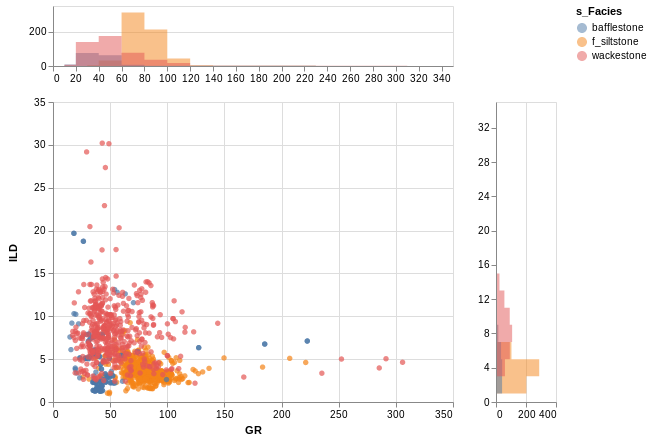

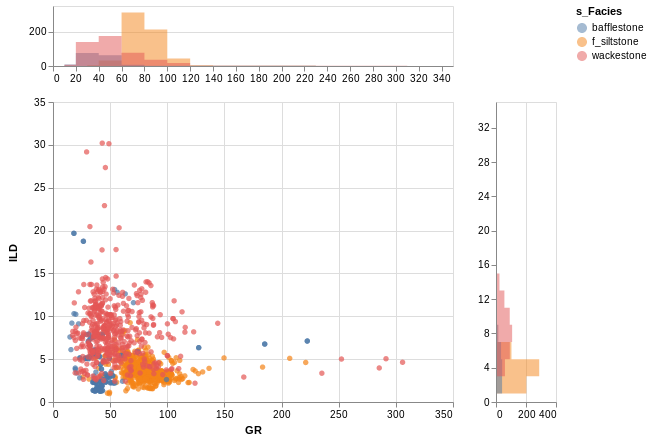

In [25]:
import altair as alt

xscale = alt.Scale(domain=(0, 350.0))
yscale = alt.Scale(domain=(0, 35))

area_args = {'opacity': .5, 'interpolate': 'step'}
blank_axis = alt.Axis(title='')

points = alt.Chart(dfs).mark_circle().encode(
    alt.X('GR', scale=xscale),
    alt.Y('ILD', scale=yscale),
    color='s_Facies',
)

top_hist = alt.Chart(dfs).mark_area(**area_args).encode(
    alt.X('GR:Q',
          # when using bins, the axis scale is set through
          # the bin extent, so we do not specify the scale here
          # (which would be ignored anyway)
          bin=alt.Bin(maxbins=20, extent=xscale.domain),
          stack=None,
          axis=blank_axis,
         ),
    alt.Y('count()', stack=None, axis=blank_axis),
    alt.Color('s_Facies:N'),
).properties(height=60)

right_hist = alt.Chart(dfs).mark_area(**area_args).encode(
    alt.Y('ILD:Q',
          bin=alt.Bin(maxbins=20, extent=yscale.domain),
          stack=None,
          axis=blank_axis,
         ),
    alt.X('count()', stack=None, axis=blank_axis),
    alt.Color('s_Facies:N'),
).properties(width=60)

top_hist & (points | right_hist)

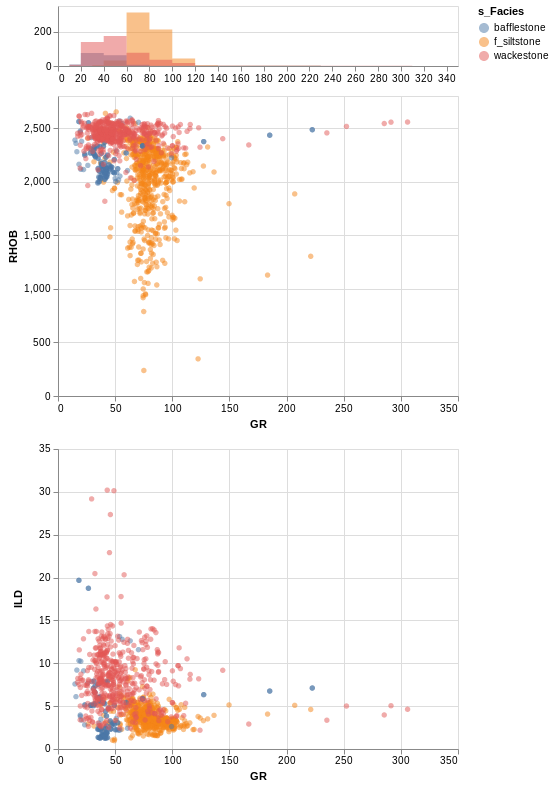

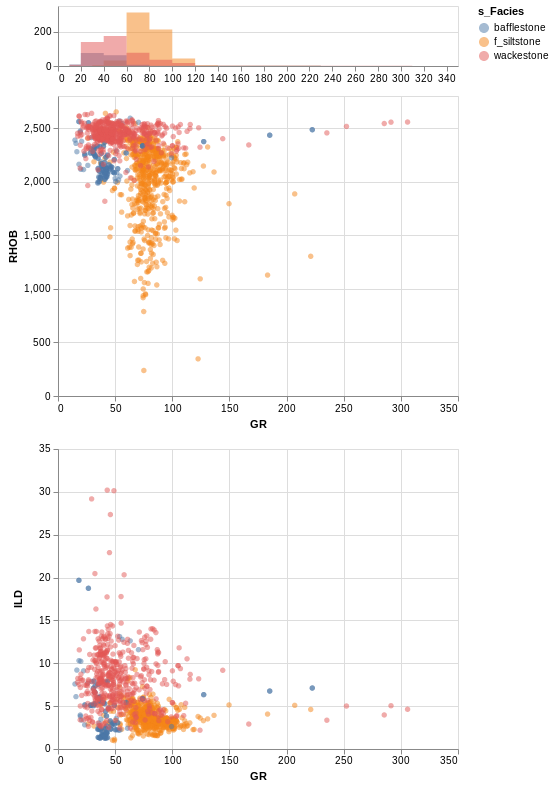

In [26]:
brush = alt.selection_interval(encodings=['x'])
color = alt.Color('s_Facies:N')
xscale = alt.Scale(domain=(0, 350.0))
yscale = alt.Scale(domain=(1.9, 4.55))

area_args = {'opacity': .5, 'interpolate': 'step'}
blank_axis = alt.Axis(title='')

c1 = alt.Chart(dfs).mark_circle(opacity=.5).encode(
    alt.X('GR', type='quantitative'),
    alt.Y('RHOB', type='quantitative'),
    color=alt.condition(brush, color, alt.value('lightgray')),
).add_selection(brush)

c2 = alt.Chart(dfs).mark_circle(opacity=.5).encode(
    alt.X('GR', type='quantitative'),
    alt.Y('ILD', type='quantitative'),
    color=alt.condition(brush, color, alt.value('lightgray')),
).add_selection(brush)

top_hist = alt.Chart(dfs).mark_area(**area_args).encode(
    alt.X('GR:Q',
          bin=alt.Bin(maxbins=30, extent=xscale.domain),
          stack=None,
          axis=blank_axis,
         ),
    alt.Y('count()', stack=None, axis=blank_axis),
    alt.Color('s_Facies:N'),
).transform_filter(brush).properties(height=60)

top_hist & c1 & c2

## Holoviews

To install, activate `geocomp` and type:
- `pip install "holoviews[recommended]"`

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
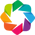

In [27]:
import holoviews as hv
hv.extension('bokeh')

In [28]:
from holoviews.operation import gridmatrix

ds = hv.Dataset(dfs[['GR','RHOB','PE','ILD_log10','s_Facies']])

In [29]:
%%opts Bivariate [bandwidth=0.5] (cmap=Cycle(values=['Blues', 'Reds', 'Oranges'])) Points (size=2 alpha=0.5)

grouped_by_facies = ds.groupby('s_Facies', container_type=hv.NdOverlay)
density_grid = gridmatrix(grouped_by_facies, diagonal_type=hv.Distribution, chart_type=hv.Bivariate)
point_grid = gridmatrix(grouped_by_facies, chart_type=hv.Points)

density_grid * point_grid

:GridMatrix   [X,Y]
   :Overlay
      .NdOverlay.I  :NdOverlay   [s_Facies]
         :Distribution   [RHOB]   (Density)
      .NdOverlay.II :NdOverlay   [s_Facies]
         :Histogram   [RHOB]   (RHOB_frequency)

<hr />

<p style="color:gray">©2017 Agile Geoscience. Licensed CC-BY.</p>